## Welcome Paul

This is a notebook made specifically for the NN project submission. We have attached our models, so there is no need to retrain them. We have plotted the loss of our most efficient model (a CNN with 4 convolutions) and compared it with other CNNs. At the end of the notebook, you will find T-SNE visualizations where we can see that a CNN with 4 convolutions is the best at splitting features during inference.

We locally stored the loss for each of our models to facilitate our visualizations and they have been attached to this submission.

A plot demonstrating early stopping is also displayed for a CNN with one convolution in this notebook and it has also been attached.

## Dataset set-up

Download data from [Kaggle](https://www.kaggle.com/datasets/toponowicz/spoken-language-identification/download?datasetVersionNumber=1) and store it in a Dataset directory where it should be unzipped into two main folders: **test** and **train**.

This is the following structure

```bash
Dataset
├── test
│   └── test
└── train
    └── train
```

Make sure to create a virtual environment and install the requirements file
```bash
pip3 install -r requirements.txt
```

In [28]:
import re
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import soundfile as sf
import librosa
import librosa.display
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, random_split
from copy import deepcopy
from torch import cuda
from IPython.display import Audio, display, Image
import copy
from tqdm import tqdm
from torch.optim import AdamW
from codecarbon import track_emissions
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer


# Hardware

Specs of hardware used during training.

```bash
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    11W /  60W |   1310MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1891      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     28468      C   ...lkative_snake/bin/python3     1302MiB |
+-----------------------------------------------------------------------------+
```

Dataloader (SpeechDataset class)

In [2]:
SEED = 42  # defining a seed to facilitate replication
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir, load_method):
        """
        :flac_dir
        """
        self.audio_path_list = sorted(self.find_files(flac_dir)) 
        methods = {"librosa": self.librosa_flac2melspec, "soundfile": self.sf_loader, "torchaudio": self.torch_flac2melspec}
        self.labels = {"es": 0, "en": 1, "de": 2}
        self.languages = {v: k for k, v in self.labels.items()}        
        self.chosen_method = methods[load_method]
        
        
    def __len__(self):
        return len(self.audio_path_list)

    def __getitem__(self, index):
        audio_file = self.audio_path_list[index]  
        label = self.labels[self.get_label(audio_file)]
        spectro, _ = self.chosen_method(audio_file)  # _ is fs        
        #spectro = torch.from_numpy(spectro)
        #spectro = spectro.unsqueeze(0)
        return spectro, label

    def find_files(self, directory, pattern=".flac"):
        """
        Recursive search method to find files. Credit to Paul Magron and Andrea de Marco
        for OG method
        """

        regexFlac = re.compile(rf'/.*fragment\d+\{pattern}$') 
        files = [f.path for f in os.scandir(directory) if regexFlac.search(f.path)]  # ends with does not like regex
        return files
    
    def monolingual_path_list(self, language, gender):
        """
        Input: string ('en'|'de'|'es')
        Output: audio path list only containing file names of the chosen language
        """
        #r = re.compile(rf'.*\/{language}_{gender}.*fragment\d+\.flac') 
        r = re.compile(rf'.*\/{language}.*fragment\d+\.flac') 
        newlist = list(filter(r.match, self.audio_path_list))
        return newlist
    
    def get_label(self, path):
        labelRegex = re.compile(r"(es|en|de)_.*.flac")
        patterns = labelRegex.findall(path)
        assert len(patterns) == 1
        return patterns[0]

    def torch_flac2melspec(self, file_path):
        pass  # commenting option to avoid pip issues on colab
        #waveform, sample_rate = torchaudio.load(file_path, normalize=True)
        #transform = T.MelSpectrogram(sample_rate)        
        #return transform(waveform), sample_rate
        
    def sf_loader(self, file_path):
        with open(file_path, "rb") as f:
            data, samplerate = sf.read(f)
        return data, samplerate

    def librosa_flac2melspec(self, file_path, n_mels=64, melspec_size=512, visual=False):
        """
        the librosa method we are using atm
        """
        sig, fs =  librosa.load(file_path, sr=None)
        sig /= np.max(np.abs(sig), axis=0)
        n_fft = melspec_size
        hop_length = int(n_fft/2)

        # padding signal if less than a second
        if len(sig) < fs:
            padded_array = np.zeros(fs)
            padded_array[:np.shape(sig)[0]] = sig
            sig = padded_array

        melspec = librosa.feature.melspectrogram(y=sig, sr=fs,
                                                 center=True, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)


        if visual:
            self.plotmelspec(melspec, fs, hop_length)

        melspec = librosa.power_to_db(melspec, ref=1.0)
        melspec /= 80.0  # highest db...
        melspec = self.checkmelspec(melspec)        
         
        
        return melspec, fs
    
    
    def checkmelspec(self, melspec, n_mels=64):
        """
        this method works with librosa

        """
        if melspec.shape[1] < n_mels:  # n_mels
            shape = np.shape(melspec)
            padded_array = np.zeros((shape[0], n_mels)) - 1
            padded_array[0:shape[0], :shape[1]] = melspec
            melspec = padded_array
        return melspec

    def plotmelspec(self, melspec, fs, hop_length, show=False):
        plt.figure(figsize=(8, 6))
        plt.xlabel("Time")
        plt.ylabel("Mel-Frequency")
        librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                                 y_axis="mel", fmax=fs/2, sr=fs,
                                 hop_length=hop_length, x_axis="time")
        plt.colorbar(format="%+2.0f db")
        plt.title("Mel Spectogram")
        plt.tight_layout()
        if show:
            plt.show()
        plt.close()  # to close windows and fix warning!

Function to get balanced subset:

In [4]:
def get_balanced_subset(train_data, n, gender):
    '''
    Creates subset with equal amounts of data from each language
    Input: instance of class Speechdataset, desired number of files per language (int) 
    Output: balanced subset (torch.utils.data.dataset.ConcatDataset)
    '''
    #create new instances for each language
    en=deepcopy(train_data)
    es=deepcopy(train_data)
    de=deepcopy(train_data)
    
    
    #modify the audio_path_list to only include paths to files of a single language
    en.audio_path_list=en.monolingual_path_list('en', gender)
    es.audio_path_list=es.monolingual_path_list('es', gender)
    de.audio_path_list=de.monolingual_path_list('de', gender)

    #extract equally sized subsets from each monolingual dataset
    en_sub = Subset(en, torch.arange(n))
    es_sub = Subset(es, torch.arange(n))
    de_sub = Subset(de, torch.arange(n))
    
    subset=en_sub+de_sub+es_sub #concatenate subsets
    return subset

utils.py

In [5]:
# https://debuggercafe.com/saving-and-loading-the-best-model-in-pytorch/

def evaluation(model, val_data, loss_fn):

    device = 'cuda' if cuda.is_available() else 'cpu'

    model.eval()
    with torch.no_grad():
        correct = 0
        loss = 0
        total = 0
        for spectra, labels in val_data:

            spectra = spectra.unsqueeze(1)
            spectra = spectra.to(device)
            labels = labels.to(device)
            preds = model(spectra)
            vals, labels_preds = torch.max(preds.data, 1) 
            total += labels.size(0)  # same as shape[0], what's more pytorch-like?
            correct += (labels_preds == labels).sum().item()
            # loss
            err = loss_fn(preds, labels)
            loss += err.item()
        total_loss = loss / len(val_data)
    return correct / total * 100, total_loss

def visualize(epochs, tr_loss, val_loss, early_stop, save=False):

    fig = plt.figure()
    train, = plt.plot(torch.arange(epochs) + 1, tr_loss, '-og', label="Train")  
    valid, = plt.plot(torch.arange(epochs) + 1, val_loss, '-ob', label="Valid")     
    if early_stop:
        early = plt.axvline(x=early_stop, color = 'r', label = 'Early Stopping', linestyle='dashed') 
        handles = [train, valid, early]
    else:
        handles = [train, valid]
        
    plt.xlabel('Epochs')
    plt.ylabel("Loss")    
    plt.legend(handles=handles)
    plt.title('Loss over epochs')
    if save:
        fig.savefig("Loss_over_epochs.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'model_output/final_speech_cnn.pth')

plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        #self.path = "./model_output/best_speech_cnn.pth"
        self.path = "model_output/best_speech_cnn.pth"
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion}, self.path)

In [6]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    # https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    def __init__(self, patience=3, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

CNNSpeechClassifier Modules

In [7]:
class CNNSpeechClassifier2D(nn.Module):

    def __init__(self, channel_inputs, num_channels1, num_channels2, num_channels3, num_channels4,
                 kernel_size, stride, kernel_pool, stride_pool, padding, num_classes):
        super(CNNSpeechClassifier2D, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(channel_inputs, num_channels1, kernel_size=kernel_size, stride=stride, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels1),
                                        nn.MaxPool2d(kernel_pool, stride=stride_pool))

        
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels2),
                                        nn.MaxPool2d(kernel_pool))


        self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels3),
                                        nn.MaxPool2d(kernel_pool))

        
        self.cnn_layer4 = nn.Sequential(nn.Conv2d(64, num_channels4, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels4),
                                        nn.MaxPool2d(kernel_pool))

        self.dropout = nn.Dropout(0.5)
        self.fc_layer = nn.Linear(num_channels4*2*9, num_classes)  # shape of cnn_layer after convolution of image!

    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = self.cnn_layer3(x)
        x = self.cnn_layer4(x)
        # vectorizing image
        z = x.reshape(x.shape[0], -1)
        z = self.dropout(z)
        return self.fc_layer(z)


train.py

In [22]:
class MyTrainer:

    def __init__(self, model, lr=1e-6):

        self.device = 'cuda' if cuda.is_available() else 'cpu'

        self.total_train_loss = []
        self.total_val_loss = []
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = copy.deepcopy(model)
        self.model.to(self.device)
        self.model.train()
        lr = 1e-3  # 1e-4 best so far?. 1e-3 
        self.optimizer = AdamW(self.model.parameters(), lr=lr)

    @track_emissions(project_name="spoken_lang_detector", offline=False, country_iso_code='FRA')
    def train_loop(self, train_data, val_data, conv_type='2D', epochs=10, verbose=True, save_local=False, visual=False):

        #https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
        early_stopping = EarlyStopping()
        save_ckp = SaveBestModel()

        early_stop_value = None
        for epoch in tqdm(range(epochs)):
            loss_curr_epoch = 0
            for spectra, labels in train_data:
                self.optimizer.zero_grad()

                if conv_type == '2D':
                    spectra = spectra.unsqueeze(1)

                spectra = spectra.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(spectra)
                loss = self.loss_fn(preds, labels)
                loss.backward()
                self.optimizer.step()

                loss_curr_epoch += loss.item()

            train_loss = loss_curr_epoch / len(train_data)
            self.total_train_loss.append(train_loss)
            acc, val_loss = evaluation(self.model, val_data, self.loss_fn)
            self.total_val_loss.append(val_loss)
            if verbose:
                self.pretty_print(epoch=epoch, train_loss=train_loss, val_loss=val_loss, acc=acc)
                
            if save_local:
                save_ckp(val_loss, epoch, self.model, self.optimizer, self.loss_fn)
            early_stopping(val_loss)

            if early_stopping.early_stop and not early_stop_value:
                early_stop_value = epoch+1
                print(f"Early stopping at epoch {early_stop_value}") 
        
        if visual:
            if not early_stop_value:
                early_stop_value = None
            visualize(epochs, self.total_train_loss, self.total_val_loss, early_stop_value, save=True)
            
        if save_local:
            save_model(epochs=epochs, model=self.model, optimizer=self.optimizer, criterion=self.loss_fn)
    
    def pretty_print(self, epoch, train_loss, val_loss, acc):
        print(f"Epoch {epoch+1}: train loss is {train_loss:.3f} | val loss is {val_loss:.3f} | Accuracy is {acc:.2f}%")

eval.py

# Data visualization

In [25]:
train_dir = "./Dataset/train/train"
train_dev_data = SpeechDataset(train_dir, "librosa")

train_size = int(len(train_dev_data) * 0.8)
val_size = len(train_dev_data) - train_size

train_data, val_data = random_split(train_dev_data, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True) 
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

all_labels = [i[1] for i in train_dev_data]  # to visualize data

In [ ]:

es_idx = all_labels.index(0)
en_idx = all_labels.index(1)
de_idx = all_labels.index(2)


def gen_audio_for_viz(idx):
    lang = all_labels.index(idx)
    return sf.read(train_dev_data.audio_path_list[lang])

es_x, es_sr = gen_audio_for_viz(0)  # 0 is spanish
en_x, en_sr = gen_audio_for_viz(1)  # 1 is english
de_x, de_sr = gen_audio_for_viz(2)  # 2 german

In [ ]:
display(Audio(data=es_x, rate=es_sr))

In [ ]:
display(Audio(data=en_x, rate=en_sr))

In [ ]:
display(Audio(data=de_x, rate=de_sr))

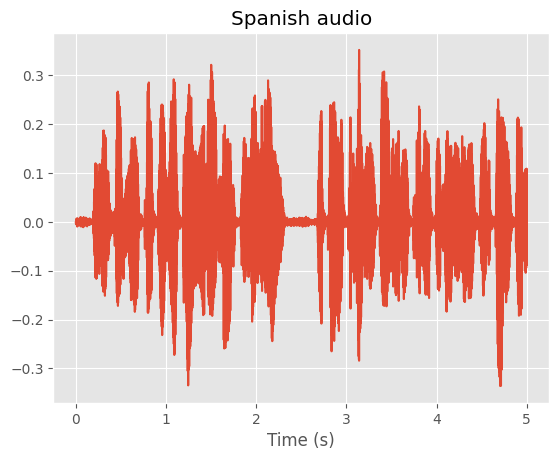

In [18]:
max_dur = 5.0  # maximum duration in seconds
max_len = int(max_dur * es_sr)  # equivalent maximum length in number of samples

y = torch.from_numpy(es_x)
sig_len = len(y)
if sig_len >= max_len:
    y= y[:max_len]
else:
    n_zeros = max_len - sig_len
    y =  torch.cat((y, torch.zeros(n_zeros)))

ty = torch.arange(len(y)) / es_sr
plt.figure()
plt.plot(ty, y)
plt.xlabel('Time (s)')
plt.title("Spanish audio")
plt.show()

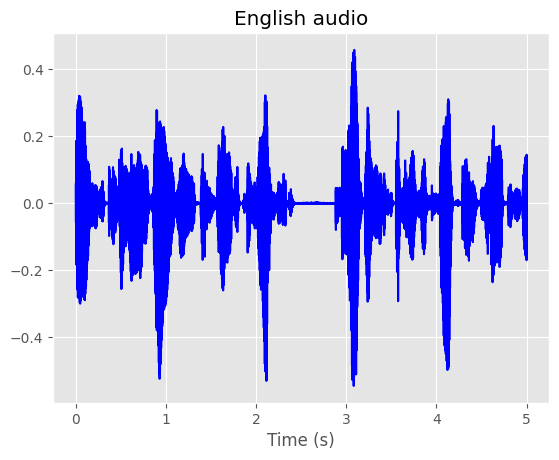

In [22]:
max_dur = 5.0  # maximum duration in seconds
max_len = int(max_dur * en_sr)  # equivalent maximum length in number of samples

y = torch.from_numpy(en_x)
sig_len = len(y)
if sig_len >= max_len:
    y= y[:max_len]
else:
    n_zeros = max_len - sig_len
    y =  torch.cat((y, torch.zeros(n_zeros)))

ty = torch.arange(len(y)) / en_sr
plt.figure()
plt.plot(ty, y, color='blue')
plt.xlabel('Time (s)')
plt.title("English audio")
plt.show()

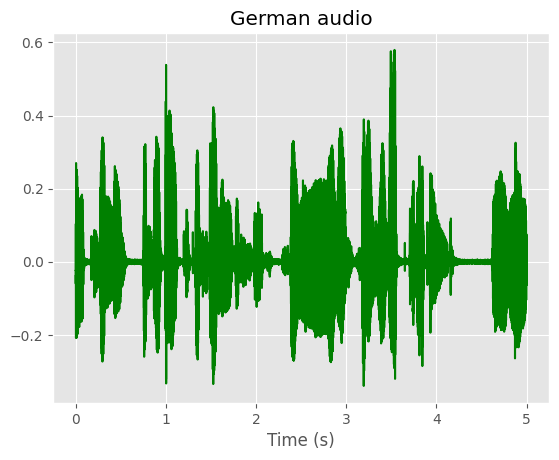

In [21]:
max_dur = 5.0  # maximum duration in seconds
max_len = int(max_dur * de_sr)  # equivalent maximum length in number of samples

y = torch.from_numpy(de_x)
sig_len = len(y)
if sig_len >= max_len:
    y= y[:max_len]
else:
    n_zeros = max_len - sig_len
    y =  torch.cat((y, torch.zeros(n_zeros)))

ty = torch.arange(len(y)) / de_sr
plt.figure()
plt.plot(ty, y, color='green')
plt.xlabel('Time (s)')
plt.title("German audio")
plt.show()

# Train

In [23]:
torch.cuda.empty_cache()  # cleaning cache before training

[codecarbon INFO @ 18:56:08] [setup] RAM Tracking...
[codecarbon INFO @ 18:56:08] [setup] GPU Tracking...
[codecarbon INFO @ 18:56:08] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:56:08] [setup] CPU Tracking...
[codecarbon ERROR @ 18:56:08] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 18:56:08] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 18:56:09] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 18:56:09] >>> Tracker's metadata:
[codecarbon INFO @ 18:56:09]   Platform system: Linux-5.19.0-32-generic-x86_64-with-glibc2.35
[

Epoch 1: train loss is 1.614 | val loss is 0.781 | Accuracy is 60.12%

Best validation loss: 0.780604430607387

Saving best model for epoch: 1



[codecarbon INFO @ 18:56:57] Energy consumed for RAM : 0.000071 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:56:57] Energy consumed for all GPUs : 0.000240 kWh. All GPUs Power : 19.461000000000002 W
[codecarbon INFO @ 18:56:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:56:57] 0.000310 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:12] Energy consumed for RAM : 0.000094 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:57:12] Energy consumed for all GPUs : 0.000321 kWh. All GPUs Power : 19.533 W
[codecarbon INFO @ 18:57:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:57:12] 0.000415 kWh of electricity used since the begining.
 20%|████████▊                                   | 2/10 [01:14<04:56, 37.12s/it]

Epoch 2: train loss is 0.847 | val loss is 0.681 | Accuracy is 69.84%

Best validation loss: 0.6810616973846678

Saving best model for epoch: 2



[codecarbon INFO @ 18:57:27] Energy consumed for RAM : 0.000118 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:57:27] Energy consumed for all GPUs : 0.000400 kWh. All GPUs Power : 18.889 W
[codecarbon INFO @ 18:57:27] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:57:27] 0.000517 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:42] Energy consumed for RAM : 0.000141 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:57:42] Energy consumed for all GPUs : 0.000478 kWh. All GPUs Power : 18.817 W
[codecarbon INFO @ 18:57:42] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:57:42] 0.000619 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:57] Energy consumed for RAM : 0.000165 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:57:57] Energy consumed for all GPUs : 0.000558 kWh. All GPUs Power : 19.042 W
[codecarbon INFO @ 18:57:57] Energy con

Epoch 3: train loss is 0.590 | val loss is 0.827 | Accuracy is 60.32%
INFO: Early stopping counter 1 of 3


[codecarbon INFO @ 18:58:12] Energy consumed for RAM : 0.000188 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:58:12] Energy consumed for all GPUs : 0.000633 kWh. All GPUs Power : 18.097 W
[codecarbon INFO @ 18:58:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:58:12] 0.000821 kWh of electricity used since the begining.
[codecarbon INFO @ 18:58:27] Energy consumed for RAM : 0.000212 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:58:27] Energy consumed for all GPUs : 0.000709 kWh. All GPUs Power : 18.251000000000005 W
[codecarbon INFO @ 18:58:27] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:58:27] 0.000921 kWh of electricity used since the begining.
[codecarbon INFO @ 18:58:42] Energy consumed for RAM : 0.000235 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:58:42] Energy consumed for all GPUs : 0.000786 kWh. All GPUs Power : 18.599 W
[codecarbon INFO @ 18:58:42

Epoch 4: train loss is 0.454 | val loss is 0.489 | Accuracy is 81.35%

Best validation loss: 0.4894581411093

Saving best model for epoch: 4



[codecarbon INFO @ 18:58:57] Energy consumed for RAM : 0.000259 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:58:57] Energy consumed for all GPUs : 0.000864 kWh. All GPUs Power : 18.575000000000003 W
[codecarbon INFO @ 18:58:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:58:57] 0.001122 kWh of electricity used since the begining.
[codecarbon INFO @ 18:59:12] Energy consumed for RAM : 0.000282 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:59:12] Energy consumed for all GPUs : 0.000941 kWh. All GPUs Power : 18.608 W
[codecarbon INFO @ 18:59:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:59:12] 0.001223 kWh of electricity used since the begining.
 50%|██████████████████████                      | 5/10 [03:14<03:15, 39.04s/it][codecarbon INFO @ 18:59:27] Energy consumed for RAM : 0.000306 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:59:27] Energy consumed fo

Epoch 5: train loss is 0.289 | val loss is 0.506 | Accuracy is 78.17%
INFO: Early stopping counter 1 of 3


[codecarbon INFO @ 18:59:42] Energy consumed for RAM : 0.000329 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:59:42] Energy consumed for all GPUs : 0.001093 kWh. All GPUs Power : 18.426000000000002 W
[codecarbon INFO @ 18:59:42] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:59:42] 0.001423 kWh of electricity used since the begining.
[codecarbon INFO @ 18:59:57] Energy consumed for RAM : 0.000353 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 18:59:57] Energy consumed for all GPUs : 0.001171 kWh. All GPUs Power : 18.676000000000002 W
[codecarbon INFO @ 18:59:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 18:59:57] 0.001524 kWh of electricity used since the begining.
 60%|██████████████████████████▍                 | 6/10 [03:53<02:35, 38.79s/it]

Epoch 6: train loss is 0.202 | val loss is 0.606 | Accuracy is 77.18%
INFO: Early stopping counter 2 of 3


[codecarbon INFO @ 19:00:12] Energy consumed for RAM : 0.000376 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:00:12] Energy consumed for all GPUs : 0.001248 kWh. All GPUs Power : 18.507 W
[codecarbon INFO @ 19:00:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:00:12] 0.001625 kWh of electricity used since the begining.
[codecarbon INFO @ 19:00:27] Energy consumed for RAM : 0.000400 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:00:27] Energy consumed for all GPUs : 0.001328 kWh. All GPUs Power : 18.989 W
[codecarbon INFO @ 19:00:27] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:00:27] 0.001727 kWh of electricity used since the begining.
 70%|██████████████████████████████▊             | 7/10 [04:23<01:48, 36.15s/it]

Epoch 7: train loss is 0.180 | val loss is 0.618 | Accuracy is 77.78%
INFO: Early stopping counter 3 of 3
INFO: Early stopping
Early stopping at epoch 7


[codecarbon INFO @ 19:00:42] Energy consumed for RAM : 0.000423 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:00:42] Energy consumed for all GPUs : 0.001407 kWh. All GPUs Power : 19.075 W
[codecarbon INFO @ 19:00:42] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:00:42] 0.001830 kWh of electricity used since the begining.
[codecarbon INFO @ 19:00:57] Energy consumed for RAM : 0.000447 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:00:57] Energy consumed for all GPUs : 0.001485 kWh. All GPUs Power : 18.739 W
[codecarbon INFO @ 19:00:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:00:57] 0.001932 kWh of electricity used since the begining.
 80%|███████████████████████████████████▏        | 8/10 [04:56<01:09, 34.96s/it]

Epoch 8: train loss is 0.189 | val loss is 0.423 | Accuracy is 85.12%

Best validation loss: 0.42251956595906187

Saving best model for epoch: 8



[codecarbon INFO @ 19:01:12] Energy consumed for RAM : 0.000470 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:01:12] Energy consumed for all GPUs : 0.001563 kWh. All GPUs Power : 18.644000000000002 W
[codecarbon INFO @ 19:01:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:01:12] 0.002033 kWh of electricity used since the begining.
[codecarbon INFO @ 19:01:27] Energy consumed for RAM : 0.000494 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:01:27] Energy consumed for all GPUs : 0.001637 kWh. All GPUs Power : 17.767000000000003 W
[codecarbon INFO @ 19:01:27] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:01:27] 0.002131 kWh of electricity used since the begining.
[codecarbon INFO @ 19:01:42] Energy consumed for RAM : 0.000517 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:01:42] Energy consumed for all GPUs : 0.001711 kWh. All GPUs Power : 17.726 W
[codecarbon INF

Epoch 9: train loss is 0.054 | val loss is 0.391 | Accuracy is 85.91%

Best validation loss: 0.39065069460221347

Saving best model for epoch: 9



[codecarbon INFO @ 19:01:57] Energy consumed for RAM : 0.000541 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:01:57] Energy consumed for all GPUs : 0.001786 kWh. All GPUs Power : 18.223 W
[codecarbon INFO @ 19:01:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:01:57] 0.002327 kWh of electricity used since the begining.
[codecarbon INFO @ 19:02:12] Energy consumed for RAM : 0.000564 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:02:12] Energy consumed for all GPUs : 0.001861 kWh. All GPUs Power : 17.857000000000003 W
[codecarbon INFO @ 19:02:12] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:02:12] 0.002425 kWh of electricity used since the begining.
[codecarbon INFO @ 19:02:27] Energy consumed for RAM : 0.000588 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:02:27] Energy consumed for all GPUs : 0.001934 kWh. All GPUs Power : 17.524 W
[codecarbon INFO @ 19:02:27

Epoch 10: train loss is 0.101 | val loss is 0.442 | Accuracy is 85.91%
INFO: Early stopping counter 1 of 3


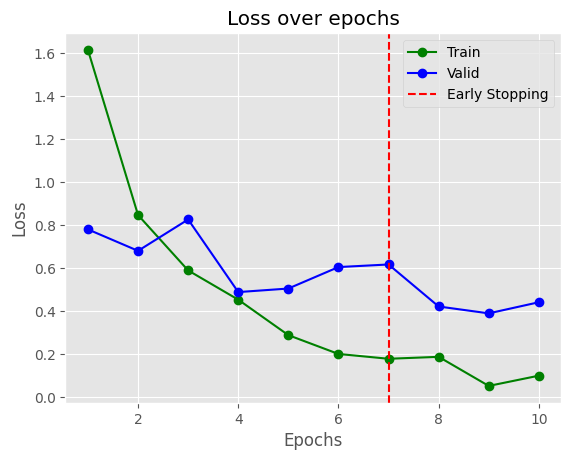

[codecarbon INFO @ 19:02:31] 
Graceful stopping: collecting and writing information.
Please Allow for a few seconds...
[codecarbon INFO @ 19:02:31] Energy consumed for RAM : 0.000595 kWh. RAM Power : 5.645008563995361 W
[codecarbon INFO @ 19:02:31] Energy consumed for all GPUs : 0.001955 kWh. All GPUs Power : 17.422 W
[codecarbon INFO @ 19:02:31] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 19:02:31] 0.002549 kWh of electricity used since the begining.
[codecarbon INFO @ 19:02:32] Done!



Saving final model...


In [26]:
kernel_size = (3, 3)
stride = (2, 2)
padding = (3, 3)
kernel_pool = 3
stride_pool = 2

CNN_model = CNNSpeechClassifier2D(channel_inputs=1, num_channels1=16,
                                num_channels2=32, num_channels3=64, num_channels4=128,
                                kernel_size=kernel_size, stride=stride,
                                kernel_pool=kernel_pool, stride_pool=stride_pool, padding=padding, num_classes=3)


trainer = MyTrainer(CNN_model)
trainer.train_loop(train_dataloader, val_dataloader, visual=True, save_local=True, epochs=10)

In [104]:
def loss_writer(loss, conv):
    """
    loss: a list containing the validation loss per epoch
    conv: an int corresponding to the number of convolutions used
    returns None. Saves file locally for further analysis
    """
    loss = [str(l) + '\n' for l in loss]
    print(loss)
    with open(str(conv) + 'd_conv-10epochs.txt', 'w') as cnn_writer:
        
        cnn_writer.writelines(loss)
    return None

#loss_writer(trainer.total_val_loss, 5)  # UNCOMMENT IF YOU WANT TO STORE THE LOSS FOR VISUALIZATION
def loss_reader(conv):
    with open(str(conv) + 'd_conv-10epochs.txt', 'r') as cnn_reader:
        
        loss = cnn_reader.readlines()
    return loss


def multiconv_visualizer(epochs=10):
    
    losses = []
    for i in range(4):
        losses.append([float(loss) for loss in loss_reader(i+1)])
    fig = plt.figure()
    val_loss_1, = plt.plot(torch.arange(epochs) + 1, losses[0], '-og', label="1 Conv")  
    val_loss_2, = plt.plot(torch.arange(epochs) + 1, losses[1], '-ob', label="2 Conv")  
    val_loss_3, = plt.plot(torch.arange(epochs) + 1, losses[2], '-or', label="3 Conv") 
    val_loss_4, = plt.plot(torch.arange(epochs) + 1, losses[3], '-oc', label="4 Conv")     
    
    
    plt.xlabel('Epochs')
    plt.ylabel("Loss")   
    plt.legend(handles=[val_loss_1, val_loss_2, val_loss_3, val_loss_4])
    plt.title('Loss over epochs')
    fig.savefig("All_model_losses.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)
    

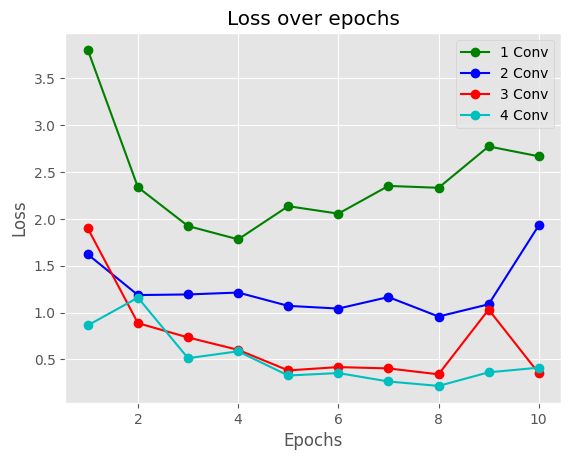

In [105]:
multiconv_visualizer()

# Early stopping demonstration

Demonstrating early stopping with a single convolution CNN

In [16]:
Image(url="1Loss_over_epochs.jpg", width=500, height=500)

Patience of 3 and delta == 0 were used for this early stopping. Note that consistently training converges around epoch 7.

# Test

In [11]:
def load_components(checkpoint):


    epoch = checkpoint["epoch"]
    loss_fn = checkpoint["loss"]

    kernel_size = (3, 3)
    stride = (2, 2)
    padding = (3, 3)
    kernel_pool = 3
    stride_pool = 2
    
    model = CNNSpeechClassifier2D(channel_inputs=1, num_channels1=16,
                                num_channels2=32, num_channels3=64, num_channels4=128,
                                kernel_size=kernel_size, stride=stride,
                                kernel_pool=kernel_pool, stride_pool=stride_pool, padding=padding, num_classes=3)
    

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    model.to(device)

    return model, optimizer, epoch, loss_fn



Main

Feel free to test the other models, but remember to change the fully connected for

- 3 Convolutions: num_channels3\*3\*25
- 2 Convolutions: num_channels2\*6\*73
- 1 Convolution: num_channels1\*16\*216

In [9]:
test_dir = "./Dataset/test/test"

test_data = SpeechDataset(test_dir, "librosa")
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)  

#best_checkpoint = torch.load("model_output/best_speech_cnn.pth", map_location=device)
best_conv = "model_output/10epoch-backup90 4conv/best_speech_cnn.pth"
ckpt_conv = torch.load(best_conv, map_location=device)
#final_checkpoint = torch.load("model_output/10epoch-backup56 1conv/final_speech_cnn.pth", map_location=device)


In [13]:
model, optimizer, epoch, loss_fn = load_components(ckpt_conv)

acc, _ = evaluation(model, test_dataloader, loss_fn)  # just need accuracy not loss...

print(f"Best epoch {epoch}: Accuracy is {acc:.2f}%")

Best epoch 7: Accuracy is 90.93%


# TSNE Embeddings

Visualization of embeddings with a trained model.

In [88]:
def compute_feature_maps(im, model):  # should be in eval model
    model.eval()
    
    out_conv1 = model.cnn_layer1(im)        
    out_conv2 = model.cnn_layer2(out_conv1)    
    out_conv3 = model.cnn_layer3(out_conv2) 
    out_conv4 = model.cnn_layer4(out_conv3) 
    feature_maps = out_conv4.detach()      
    #print(feature_maps4.shape)  # 128, 2, 9
    return feature_maps

In [89]:
def gen_f_maps_labels(model, t_dataloader, batch_size=8):
    len_dataset = len(t_dataloader) * batch_size # batch_size
    feature_maps_tot = torch.empty((len_dataset, 128*2*9), dtype=torch.float)  # 128, 2, 9 after convolution spec loses dim
    labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
    feature_maps_tot = feature_maps_tot.to(device)
    labels_im_tot = labels_im_tot.to(device)

    with torch.no_grad():
        for ib, (spec, labels) in enumerate(t_dataloader):

            spec = spec.unsqueeze(1)                            
            spec = spec.to(device)            
            labels = labels.to(device)
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)  # batch_size
            labels_im_tot[indices_b] = labels.float()
            
            feature_map = compute_feature_maps(spec, model) 
            in_im_vec = feature_map.reshape(batch_size, -1)  # batch_size         
            feature_maps_tot[indices_b, :] = in_im_vec
            
    feature_maps_tot = feature_maps_tot.to('cpu')
    labels_im_tot = labels_im_tot.to('cpu')
    feature_maps_tot = feature_maps_tot.numpy()
    labels_im_tot = labels_im_tot.numpy()
    return feature_maps_tot, labels_im_tot

feature_maps_tot, labels_im_tot = gen_f_maps_labels(model, train_dataloader)

In [90]:
feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
print('Size TSNE embeddings (input melspectograms):', feature_maps_TSNE.shape)

/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Size TSNE embeddings (input melspectograms): (2016, 2)


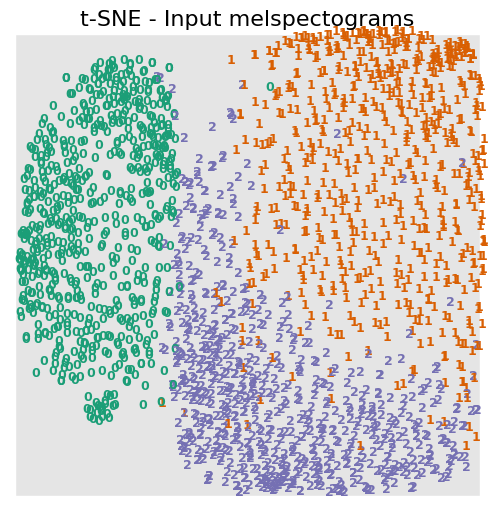

In [91]:
def plot_tsne_embeddings(X, y, title, save=False):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    fig = plt.figure(figsize = (6,6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    if save:
        fig.savefig(f"t-SNE_Input_mels.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    
    return
plot_tsne_embeddings(feature_maps_TSNE, labels_im_tot, 'Input melspectograms')

Label 0 is for Spanish, 1 represents English, and German is labeled as 2

# Best number of epochs
- The epoch with the best loss for 4 convolutions was number: 8
- The epoch with the best loss for 3 convolutions was number: 9
- The epoch with the best loss for 2 convolutions was number: 8
- The epoch with the best loss for 1 convolutions was number: 4

|             | Accuracy | Early Stopping Epoch |
|-------------|----------|----------------------|
| CNN 4 conv. | 90%      | 8                    |
| CNN 3 conv. | 88%      | 9                    |
| CNN 2 conv. | 69%      | 8                    |
| CNN 1 conv. | 56%      | 4                    |

This means the average number of epochs before early stopping is 7. I.e. training the network for more than 7 epochs is not worth it.

# Why 4 convolutions?

Now we will load the T-SNE embeddings from the other CNNs to demonstrate how poorly they were in terms of detecting different classes

In [18]:
Image(url="tsne-1d.png", width=400, height=400)



In [19]:
Image(url="tsne-2d.png", width=400, height=400)



In [20]:
Image(url="tsne-3d.png", width=400, height=400)

At the very least we can observe that around 3 convolutions the model improves its class recognition during inference

# Environmental cost

In [29]:
green_df = pd.read_csv("emissions.csv")
green_df

,timestamp,project_name,run_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,...,python_version,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud
0,2023-02-21T19:02:32,spoken_lang_detector,ceb22988-edbc-4514-bb3d-f26aa1b77e90,379.481012,0.00014,0.000369,0.0,17.422,5.645009,0,...,3.10.6,16,AMD Ryzen 7 4800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3050 Laptop GPU,6.1862,48.6822,15.053356,machine,N


# Possible improvements

- A cyclic learning rate scheduler instead of early stopping, but is a learning rate scheduler worth it for this problem? [Perhaps there can be another solution](https://towardsdatascience.com/why-using-learning-rate-schedulers-in-nns-may-be-a-waste-of-time-8fa20339002b)
- Hyperparametrize
- Add weights and biases for logging
- Complete a 3D T-SNE visualization embedding before training
- Compare results with a HMM
- Visualize environmental cost with matplot instead of their API as their dash module is outdated
